[Inspiration by Daniel Voigt Godoy's books](https://pytorchstepbystep.com/)

# Linear regression

In [ ]:
import platform
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from pytorched.step_by_step import StepByStep

from torchviz import make_dot
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Generate some data

we'll use numpy for this, and also need to split the data, can also use numpy for this

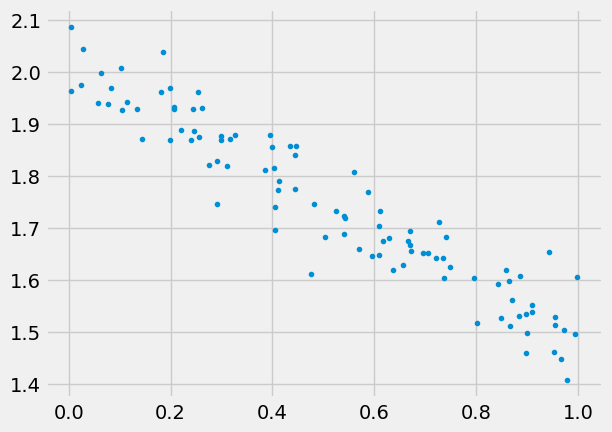

In [ ]:
np.random.seed(43)

b_true = 2.
w_true = -0.5
N = 100

x = np.random.rand(N,1)
epsilon = 0.05 * np.random.randn(N,1)
y = w_true*x + b_true + epsilon

plt.plot(x,y,'.')
plt.show()

# Linear regression with sklearn

Of course we can make a fit using sklearn:

In [ ]:
reg = LinearRegression().fit(x, y)
r2_coef = reg.score(x, y)
print(reg.coef_, reg.intercept_, r2_coef)

[[-0.52894853]] [2.01635764] 0.9014715901595961


but the point is to learn PyTorch and solve much bigger problems.

# Create datasets, data loaders

- data set is the object that holds features and labels together, 
- split the data into train and valid,
- convert to pytorch tensors,
- create datasets,
- create data_loaders.

In [ ]:
np.random.seed(43)
indices = np.arange(N)
np.random.shuffle(indices)
train_indices = indices[:int(0.8*N)]
val_indices = indices[int(0.8*N):]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_x = torch.tensor(x[train_indices], dtype=torch.float32, device=device)
train_y = torch.tensor(y[train_indices], dtype=torch.float32, device=device)
val_x = torch.tensor(x[val_indices], dtype=torch.float32, device=device)
val_y = torch.tensor(y[val_indices], dtype=torch.float32, device=device)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model, loss, and optimizer

In [ ]:
torch.random.manual_seed(42)
model = torch.nn.Linear(1,1, bias=True, device=device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# Train

In [ ]:
model.reset_parameters()
sbs = StepByStep(model, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)
sbs.train(30)

In [ ]:
sbs.model.state_dict()

OrderedDict([('weight', tensor([[-0.5267]])), ('bias', tensor([2.0177]))])

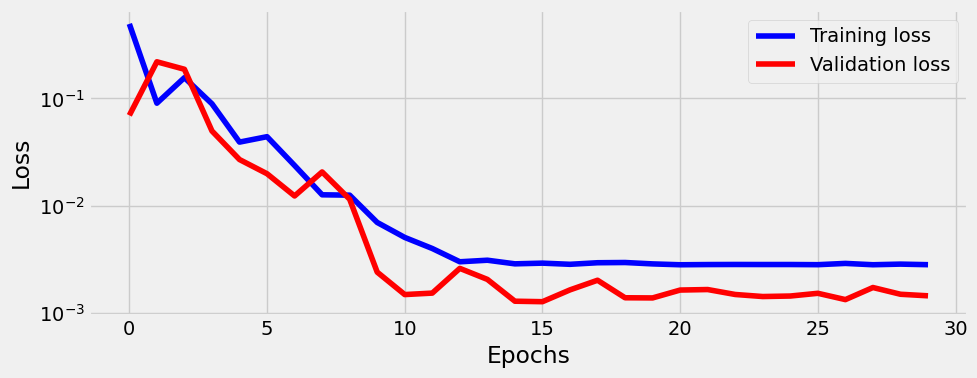

In [ ]:
sbs.plot_losses()

Note btw that `alex` and `sbs.model` are the same object:

In [ ]:
assert id(sbs.model) == id(model)

# Predict

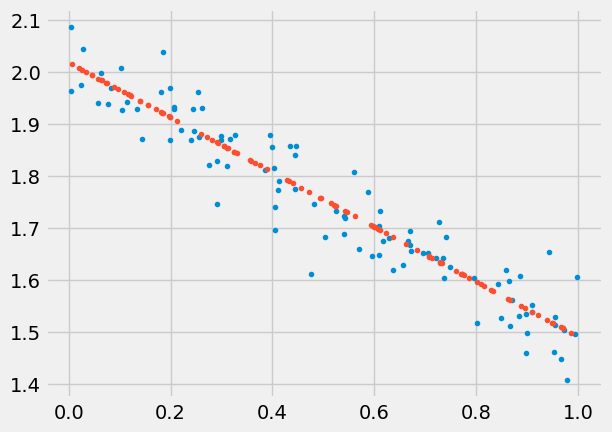

In [ ]:
test = np.random.rand(100,1)
test_predictions = sbs.predict(test)
plt.plot(x,y,'.')
plt.plot(test,test_predictions,'.')
plt.show()

#  Save/load model

In [ ]:
sbs.save_checkpoint('pera.pth')

In [ ]:
sbs.load_checkpoint('pera.pth')

# Visualize model

One can use `make_dot(yhat)` locally. I can't make graphviz work on GitHub, but the output looks like this:

<img width="300" src="images/linear_regression_model.jpg"/>

In [ ]:
#| hide 
if 'macOS' in platform.platform():
    yhat = sbs.model(torch.rand(10,1))
    make_dot(yhat)
# on Github getting error ExecutableNotFound: failed to execute Path('dot'), 
# make sure the Graphviz executables are on your systems' PATH

# Set up tensorboard

One can add tensorboard to monitor losses, this will be important when having long training. We can start tensorboard from terminal using `tensorboard --logdir runs` (or from notebook if using extension via `%load_ext tensorboard`). The tensorboard should be running at http://localhost:6006/ (ignore `"TensorFlow installation not found"` message, we don't need it). Make sure path is right, tensorboard will be empty if it can't find the `runs` folder. 

In [ ]:
#| hide
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#| hide
# tensorboard --logdir runs  # this line must sit in it's own cell not even had #| hide flag above

In [ ]:
#| hide
model.reset_parameters()
sbs = StepByStep(model, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('linear_classification')
sbs.train(30)